# An Autoencoder's Compression to Measure the Complexity of Text

I developed this idea while working on a project that measures the quality of EU legislation. The core concept of this notebook is to exploit the compression quality of an autoencoder as an indication of the complexity of a sentence. This idea aims to contribute to the NLP literature by measuring complexity in text.

I propose to use an autoencoder model that consists of two parts: an encoder and decoder. The encoder encodes an input into a lower embedding space than the original input size through several non-linear hidden layers. This is the concept of a bottleneck, which has the lowest layer size. From this bottleneck, the decoder model has to reproduce the original input with just the information available at the bottleneck. The compression takes place exactly at this bottleneck. The replicated sentence is then compared to the original input, ensuring that the input equals the output. A simple autoencoder architecture is illustrated below (from Google Images).

The idea, to reiterate, is that more complex sentences are harder to compress, which is associated with a higher loss when passing this sentence during inference time through the model. I will first load a sample sentence from a Wikipedia dataset, then build and train the model, and finally illustrate with mock sentences that the above idea indeed works.

I plan to extend the method by adding further enhancements to the model (dropout layers, layer normalization, learning rate decay, etc.) to optimize the autoencoder.

In [16]:
# Load packages
import torch
import torch.nn as nn
from torch.nn import functional as F
import matplotlib.pyplot as plt
import numpy as np 
import random

# For
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [17]:
# For efficien computing
# torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it'll return False
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU not available, CPU used


## Data

Here I used a Wikipedia dataset. I will use the EU legislation set next to see the methods application to our data.

In [18]:
# Load data 
with open('/Users/gerritquaremba/Library/CloudStorage/GoogleDrive-g.quaremba@gmail.com/My Drive/08_NN_Kaparthy/data/wikisent2.txt', 'r', encoding='utf-8') as f:
    text=f.read()

In [19]:
# Split the data into a list of setnences
text = text.split('\n')

# Shuffle and select x sentences
random.seed(42)
random.shuffle(text)
text=text[:2000]

# DO: shuffle at this stage 

# Keep only sentences of a certain size and lower each
text = [t.lower() for t in text if len(t)<=400]
text[:3]

['imanol sarriegi isasa (born 27 april 1995) is a spanish footballer who plays as a central midfielder.',
 'indeed, the greater part of this chisian daniel cannot be said to deserve the name of a translation at all.',
 'after moving to los angeles to become an actor, rambo started working in the real estate business.']

In [20]:
# Number of sentences for training
len(text)

1998

Currently, we are on char-level, can also change this of course.

In [21]:
# Set of unique chars
chars = set(''.join(text))

# Length of chars
vocab_size = len(chars)
vocab_size

57

In [22]:
# Int to chat
int2char = dict(enumerate(chars))

# Char to int
char2int = {char: ind for ind, char in int2char.items()}

In [23]:
# Longest sentence
maxlen = len(max(text, key=len))
maxlen

384

In [24]:
# Apply padding
for i in range(len(text)):
  while len(text[i])<maxlen:
      text[i] += ' '

In [25]:
# Check sentences
text[:2]

['imanol sarriegi isasa (born 27 april 1995) is a spanish footballer who plays as a central midfielder.                                                                                                                                                                                                                                                                                           ',
 'indeed, the greater part of this chisian daniel cannot be said to deserve the name of a translation at all.                                                                                                                                                                                                                                                                                     ']

Define the input and output tensors, which are the same for the autoencoder!

In [26]:
# Get in and out
inout = []

for i in range(len(text)):
    inout.append([char2int[character] for character in text[i]])

In [27]:
# Create a tensor
inout = torch.tensor(inout, dtype=torch.long)
inout.shape

torch.Size([1998, 384])

`inout` is of size `(B, T)`. We have set `T` above to be a bit shorter. A batch is an epoch here.

## Autoencoder Architecture

Below implements the AC. The optimal architecture is to be determined. Currently, the bottleneck is of dim `(8,8)`.

In [28]:
# AE
class AE(nn.Module): # inherent from the nn class

    def __init__(self):
        super().__init__()
        
        # Create embedding matrix
        self.token_embedding_table = nn.Embedding(vocab_size, n_embed) # This is a 65 x n_embed matrix; weights are inintialised at random
        
    
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(n_embed, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 8),
            nn.ReLU()
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(8, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, n_embed)
        )
   
    def forward(self, idx):

       # Get embeddings
        embeddings = self.token_embedding_table(idx)

        # Encode
        encoded = self.encoder(embeddings)

        # Decode
        reconstructed = self.decoder(encoded)

        # Compute loss
        loss = F.mse_loss(reconstructed, embeddings)

        return reconstructed, loss

In [29]:
# Initialise model and HPs
# Hyperparameters
n_embed=64
batch_size=len(text)
max_iters = 500
learning_rate=1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Model
model = AE()
m = model.to(device)

In [30]:
# Training

# PyTorch optimiser
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

for step in range(max_iters):

    # Forward pass
    _, loss = model(inout)

    # Set gradients to 0
    optimizer.zero_grad(set_to_none=True) # more efficient

    # Backprop
    loss.backward()

    # Adam, update gradients
    optimizer.step()

    # Print final loss (batch loss)
    if step % 100  == 0:
        print(f"Step[{step}/{max_iters}] loss: {loss.item()}")

Step[0/500] loss: 1.030594825744629
Step[100/500] loss: 0.20748566091060638
Step[200/500] loss: 0.10281094163656235
Step[300/500] loss: 0.03909117728471756
Step[400/500] loss: 0.019519690424203873


From observing the training loss we cann tell that the optimisation works. But there is considerable room for improvement!

### Compression as a measure for text complexity?

The intuition is that a sentence that is more complex (longer, more complex syntax, etc) is more difficult to compress and and rebuild, whicch is indicated with a higher loss during inference. Below I test exaclty this. For the evaluation, I took a simple comparsion of the loss. But a more intuitive measure would be to take the logits and compute the probability of the sentence. (Is this entropy?)

In [31]:
# Method to get loss for a sentence
def compression_score(model, sent):


    model.eval() # eval mode
  
    # Pre sentence for input into the mdoel
    sent = sent.lower()

    # Apply padding
    while len(sent)<maxlen:
      sent += ' '

    # Sentecne to idx, and tensor with batch dim 1
    sent_idx = [char2int[character] for character in sent] # 
    sent_idx = torch.tensor(sent_idx, dtype=torch.long).view(1, maxlen)
    
    # Output the logits
    _, loss = model(sent_idx)
    
    return loss.item()

In [32]:
# Comparison of scores
compression_score(model, "Hello there") < compression_score(model, "Hello there this is likely more difficult, becasue it contains more text.")

True

The losses differ considerably:

In [33]:
# Difficult sentence
compression_score(model, "Hello there. This is likely more difficult, because it contains more text.")

0.00559005094692111

In [34]:
# Easier sentence
compression_score(model, "Hello there")

8.399781654588878e-05

One concern that may drive the above result is that sheer length is driving the comeplexity of a sentence. Let us test same length but more complicated syntax/grammar.

In [35]:
# Same length, different complexity
compression_score(model, "This is a sentence that has the same length as the other sentence.") < compression_score(model, "This is, by far, a more convoluted sentence; hence more complex.")

True

In [36]:
# Easy sentence
compression_score(model, "This is a sentence that has the same length as the other sentence.")

0.0012742517283186316

In [37]:
# Complex sentence
compression_score(model, "This is, by far, a more convoluted sentence; hence more complex.")

0.005911217536777258

Seems to look good! More in the near future!

Prompt: Please return a Python list with 30 sentences that would be considered easy to read. Vary these sentences by topic, length, grammar, spelling, and vocabulary. Please consider a wide range of lengths. Provide these 30 easy sentences in a list as strings:

In [39]:
easy_sentences = [
    "The cat sleeps on a warm, sunny windowsill.",
    "Apples grow on trees and are usually red or green.",
    "She goes for a walk in the park every morning.",
    "The moon shines brightly at night in the sky.",
    "He loves playing soccer with his friends on weekends.",
    "Butterflies have colorful wings and fly from flower to flower.",
    "A big, red ball bounced down the hill.",
    "She baked chocolate chip cookies for the bake sale.",
    "Birds sing early in the morning during summer.",
    "The book on the table is about dinosaurs.",
    "He waters his plants in the garden every day.",
    "Fish swim in the water and have fins.",
    "It rains a lot in the spring and flowers bloom.",
    "The dog barked loudly when the mailman arrived.",
    "She wears a warm hat and gloves in the winter.",
    "They watched a movie at the cinema last night.",
    "The little boy climbed up the tree quickly.",
    "She loves drawing pictures and coloring with crayons.",
    "The train travels fast and carries many passengers.",
    "Elephants are large animals with long trunks.",
    "He ate a sandwich and an apple for lunch.",
    "Stars are far away and shine in the night sky.",
    "The teacher read a story to the class.",
    "A rainbow has many colors and appears after rain.",
    "The clock on the wall shows the correct time.",
    "The baby laughed when she played peek-a-boo.",
    "He learned how to ride a bike last summer.",
    "She wore a pretty dress to her friend's birthday party.",
    "The car stopped at the red light on the street.",
    "They went to the beach and built a sandcastle."
]


Prompt: Please return a Python list with 30 sentences that would be considered difficult to read. Vary these sentences by topic, length, grammar, spelling, and vocabulary. Please consider a wide range of lengths. Provide these 30 difficult sentences in a list as strings:

In [42]:
difficult_sentences = [
    "In microeconomic theory, the concept of a Pareto efficient allocation is pivotal to the understanding of equilibrial dynamics.",
    "Epistemological inquiries in the realm of metaphysics often juxtapose the ontological paradigms of realism and idealism.",
    "The pathophysiological mechanisms underlying idiopathic pulmonary fibrosis remain an enigma in respiratory medicine.",
    "Phenomenological hermeneutics, as propounded by Heidegger, delineates the interpretative frameworks of existential ontology.",
    "Quantum electrodynamics encompasses the intricate interplay between photons and charged particles, governed by probabilistic principles.",
    "Geostationary satellites, owing to their synchronous orbit with the Earth's rotation, are instrumental in meteorological observations.",
    "Constitutional jurisprudence frequently grapples with the dichotomy between civil liberties and governmental prerogatives.",
    "Psychoanalytic theories, particularly those of Freud and Jung, delve into the intricacies of the human subconscious.",
    "In the realm of abstract algebra, the properties of groups, rings, and fields are foundational to modern mathematical discourse.",
    "Post-colonial literary criticism often deconstructs the narratives of cultural hegemony embedded in erstwhile colonial literature.",
    "The philosophical discourse on existentialism primarily contemplates the intrinsic absurdity and futility of human existence.",
    "Astrophysical observations of quasars elucidate the phenomena of supermassive black holes at the centers of distant galaxies.",
    "In the field of bioinformatics, genomic sequencing techniques are revolutionizing our understanding of genetic predispositions.",
    "The geopolitical landscape in the post-Cold War era is marked by the emergence of multipolar international relations.",
    "Behavioral economics integrates psychological insights into the analysis of consumer decision-making patterns.",
    "The thermodynamic principles underlying cryogenic engineering facilitate the liquefaction and separation of gases.",
    "Surrealist art, exemplified by the works of Salvador Dali, juxtaposes dreamlike absurdities with meticulous realism.",
    "In linguistics, the study of morphemes and phonemes is central to the understanding of language formation and structure.",
    "The principle of superposition in quantum mechanics challenges the classical conceptions of reality and causality.",
    "Dadaism, as an avant-garde movement in art, sought to defy the conventional aesthetics and cultural hierarchies.",
    "Neuropsychological assessments are pivotal in diagnosing and understanding the spectrum of cognitive impairments.",
    "The intricacies of diplomatic negotiations often hinge upon the subtle art of political brinkmanship and tact.",
    "Endocrinological disorders, such as diabetes and thyroid dysfunctions, have multifaceted implications for overall health.",
    "In developmental psychology, the stages of cognitive development proposed by Piaget provide a framework for understanding child psychology.",
    "The doctrine of judicial review plays a critical role in the balance of power within constitutional governments.",
    "Theories of international trade, such as comparative advantage, elucidate the dynamics of global economic interdependence.",
    "Understanding the biochemical pathways involved in photosynthesis is essential to the study of plant physiology.",
    "Renaissance art, characterized by its emphasis on classical humanism and realistic perspective, marked a departure from medieval artistic conventions.",
    "The study of tectonic plate movements is integral to the science of geology and our understanding of Earth's history.",
    "Deconstructive criticism, as a form of literary analysis, seeks to unravel the inherent ambiguities and contradictions in a text."
]


In [43]:
# Get compression lost for each list
easy_losses = [compression_score(model, s) for s in easy_sentences]

diff_losses = [compression_score(model, s) for s in difficult_sentences]

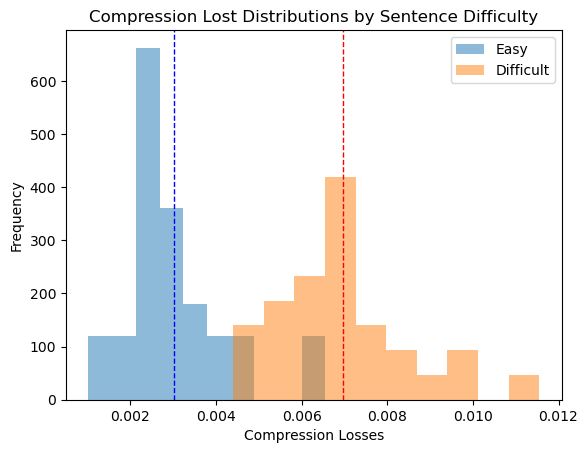

In [49]:
# Plot

plt.hist(easy_losses, alpha=0.5, label='Easy')
plt.hist(diff_losses, alpha=0.5, label='Difficult')

plt.axvline(np.mean(easy_losses), color='blue', linestyle='dashed', linewidth=1)
plt.axvline(np.mean(diff_losses), color='red', linestyle='dashed', linewidth=1)

plt.legend()
plt.xlabel('Compression Losses')
plt.ylabel('Frequency')
plt.title('Compression Lost Distributions by Sentence Difficulty')

# Show plot
plt.show()
